In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

from sklearn.mixture import GMM # today's workhorse!

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Our data today comes from a proper motion study of the classic open cluster M67 by [Yadav et al. (2008)](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/A%2bA/484/609)

In [21]:
# read the data in
file = 'data/J_A+A_484_609_catalog.dat'

df = pd.read_table(file, delimiter='|', skiprows=5, header=None,
                  names=['seq','coord','xpos','ypos','B','Berr','V','Verr','I','Ierr','pmRA','pmRAerr',
                         'pmDE','pmDEerr','Pmb','HRV','e_'])
#df

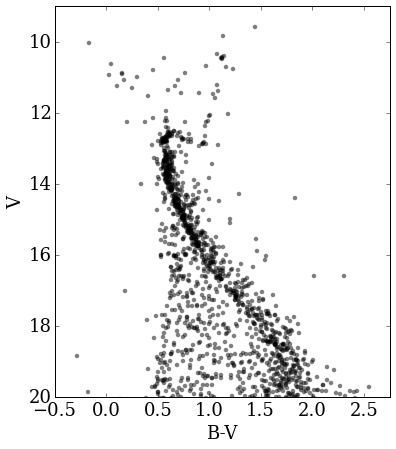

In [22]:
# plot a Color vs Magnitude Diagram (CMD)
plt.figure(figsize=(6,7))
plt.scatter(df['B'] - df['V'], df['V'], alpha=0.5, lw=0, c='k')
plt.xlim(-0.5, 2.75)
plt.ylim(20, 9)
plt.xlabel('B-V')
plt.ylabel('V')

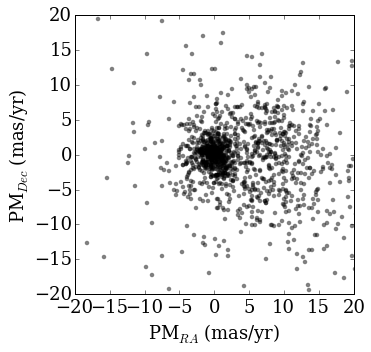

In [23]:
# get rid of noisy and missing data from the CMD above
# also clip the outliers in the PM diagram
x = np.where((df['B'] < 23) & (df['V'] < 20) & 
            (np.abs(df['pmRA']) < 30) & (np.abs(df['pmDE']) < 30))

# plot the proper motions against eachother 
plt.figure(figsize=(5,5))
plt.scatter(df['pmRA'].values[x], df['pmDE'].values[x], alpha=0.5, lw=0, c='k')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel('PM$_{RA}$ (mas/yr)')
plt.ylabel('PM$_{Dec}$ (mas/yr)')

# Gaussian Mixture Model

Let's try to model the Proper Motion Diagram using GMM. We'll use this to classify **cluster** versus **field** stars. These classifications will then be used to clean up the CMD above!

We're going to loosely follow the sklearn [example on GMM](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_classifier.html), and also a very [useful blog post](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) by Jake VanderPlas that uses GMM

In [24]:
# data = np.stack((df['pmRA'].values[x], df['pmDE'].values[x])).T
data = np.array((df['pmRA'].values[x], df['pmDE'].values[x])).T
data.shape

(1326, 2)

In [25]:
gmm_model = GMM(n_components=2, # tell it how many Gaussians to fit
                covariance_type='spherical' # what type of Gaussian to fit?
         )
gmm_model.fit(data)
clabel = gmm_model.predict(data)
clabel.shape

(1326,)

In [26]:
print(gmm_model.predict_proba(data)[100,:], clabel[100])
probs = gmm_model.predict_proba(data)

(array([  3.91531267e-04,   9.99608469e-01]), 1)


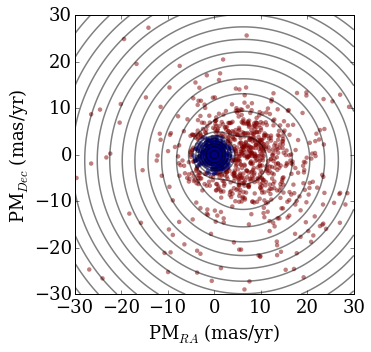

In [66]:
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], alpha=0.5, lw=0, c=clabel)
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.xlabel('PM$_{RA}$ (mas/yr)')
plt.ylabel('PM$_{Dec}$ (mas/yr)')

x = np.linspace(-30.0, 30.0, 100)
y = np.linspace(-30.0, 40.0, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 77), colors='k', alpha=0.5, linewidths=1.5)

plt.savefig('pm.png', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

If you wanted to plot *contours* for each of the Gaussians, you could follow [this example](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py)

In [ ]:
plt.figure(figsize=(6,7))
plt.scatter(df['B'].values[x] - df['V'].values[x], df['V'].values[x], alpha=0.5, lw=0, c=clabel)
plt.xlim(-0.5, 2.75)
plt.ylim(20, 9)
plt.xlabel('B-V')
plt.ylabel('V')

In [ ]:
cl = np.where((clabel == 0))

plt.figure(figsize=(6,7))
plt.scatter(df['B'].values[x][cl] - df['V'].values[x][cl], df['V'].values[x][cl], alpha=0.5, lw=0, c='k')
plt.xlim(-0.5, 2.75)
plt.ylim(20, 9)
plt.xlabel('B-V')
plt.ylabel('V')

There is so much more to learn about Machine Learning for astronomy. 

I would *highly* suggest flipping through these [videos](https://www.youtube.com/playlist?list=PLzWVyeIO6Cmt1cWrzwF2yqW-9j5TgyQaD) and IPython [notebooks](https://github.com/jakevdp/ESAC-stats-2014) produced by Jake VanderPlas from 2014, which give practical examples of using machine learning in astronomy.

ALSO, be sure to pick up a copy of [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.amazon.com/Statistics-Mining-Machine-Learning-Astronomy/dp/0691151687)

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(df['xpos'].values[x], df['ypos'].values[x], c=clabel, alpha=0.5, lw=0)


In [ ]:

plt.scatter(probs[:,0]*100., df['Pmb'].values[x])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,2e2)
plt.xlim(1e-5,2e2)